In [1]:
import numpy as np
import matplotlib
import math
from matplotlib import pylab as plt
import pandas as pd
import scipy
from tqdm import tqdm,tqdm_notebook


In [10]:
NUMBER_X = 100
NUMBER_Y = 100
X_MAX = NUMBER_X
Y_MAX = NUMBER_Y
X_STEP = 1
Y_STEP = 1
X_FACE = X_STEP
Y_FACE = Y_STEP

AREA_PART = 0.2
AREAS_X = int(AREA_PART*NUMBER_X)
AREAS_Y = int(AREA_PART*NUMBER_Y)

X_1 = AREAS_X
X_2 = X_MAX - AREAS_X
X_M = X_MAX

Y_1 = AREAS_Y
Y_2 = Y_MAX - AREAS_Y
Y_M = Y_MAX

x_set = np.arange(0, X_MAX, X_STEP)
y_set = np.arange(0, Y_MAX, Y_STEP)

temp = np.zeros((len(x_set), len(y_set)))
lambda_set = np.ones((len(x_set), len(y_set)))
source_c = np.zeros((len(x_set), len(y_set)))
source_p = np.zeros((len(x_set), len(y_set)))



In [11]:
def heatmap2d(arr: np.ndarray, interpolation=None):
    fig = plt.figure(figsize = (10,10))
    plt.imshow(arr.T, cmap='magma', interpolation=None)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    
    ax = plt.gca()
    ax.invert_yaxis()

#Кружочек
# @lru_cache(maxsize=None)
def create_circular_mask(h, w, radius):
    center = [int(h/2), int(w/2)]
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [12]:
#Константы температуры и потока

T_ZERO = 0
T_INNER_1 = 100
T_INNER_2 = 120
T_AREA_1 = 150
T_CIRCLE = 150
T_LEFT = 100
T_RIGHT = 100
T_UP = 100
T_LOW = T_ZERO
T_INNER = 50

LAMBDA_ZERO = 10**(-20)

Q_ZERO = 0 #слева, справа, снизу, в областях 1 и 3
Q_AREA_4 = 500
Q_UP = 5*LAMBDA_ZERO*10**(1)

LAMBDA_INF = 10**20
LAMBDA_CIRCLE = 10**15

M = 10**20

RADIUS = int(AREA_PART*NUMBER_X)



In [13]:
#Задание внутренних граничных условий
lambda_set = np.ones((len(x_set), len(y_set)))
#area 3 (X_2:X_M, 0:Y_1)
lambda_set[X_2 + 1:X_M, 0:Y_1  - 1] = LAMBDA_ZERO

#area 1 (X_2:X_M, Y_2:Y_M)
lambda_set[X_2:X_M, Y_2:Y_M] = LAMBDA_INF

#area 2 (circle)
mask_circle = create_circular_mask(X_MAX, Y_MAX,RADIUS)
lambda_set[mask_circle] = LAMBDA_CIRCLE
source_p[mask_circle] = M 
source_c[mask_circle] = M*T_CIRCLE 

#area 4 (0:X_1, 0:Y_1)
lambda_set[0:X_1 - 1, 0:Y_1 - 1] = LAMBDA_ZERO
source_c[0:X_1 + 1, 0:Y_1 + 1] = 2*Q_AREA_4/X_STEP
source_p[0:X_1 + 1, 0:Y_1 + 1] = 2*Q_AREA_4/X_STEP

#area 5 (0:X_1, Y_2:Y_M)
lambda_set[0:X_1 - 1, Y_2 + 1:Y_M] = LAMBDA_ZERO
source_c[X_1 + 1, Y_2:Y_M] = 2*lambda_set[X_1 + 1, Y_2:Y_M]*T_INNER_2/X_STEP
source_p[X_1 + 1, Y_2:Y_M] = 2*lambda_set[X_1 + 1, Y_2:Y_M]/X_STEP
source_c[0:X_1, Y_2 - 1] = 2*lambda_set[0:X_1, Y_2 - 1]*T_INNER_1/X_STEP
source_p[0:X_1, Y_2 - 1] = 2*lambda_set[0:X_1, Y_2 - 1]/X_STEP

lambda_set[X_1:X_2, Y_M  - 1] = 1

In [14]:
#heatmap2d(lambda_set)

In [15]:
def coef_calc(alpha, betha, kind, lambds, t, t_up, t_low, s_c, s_p, lambds_up, lambds_low):
    #lambds - лямбды на оси неизвестных, lambds_up & lambds_low - лямбды выше и ниже (справа и слева)
    if kind == 'long':
        size_x = X_STEP
        size_y = Y_STEP
        
    elif kind == 'trans':
        size_x = Y_STEP
        size_y = X_STEP
        
    with np.errstate(divide='ignore', invalid='ignore'):
        a = np.roll(lambds, 1) / (np.roll(lambds, 1) + lambds) / size_x ** 2
        b = np.roll(lambds, -1) / (np.roll(lambds, -1) + lambds) / size_x ** 2             
        c = (((np.roll(lambds, -1) + np.roll(lambds, 1)) * lambds + 
            2 * np.roll(lambds, -1) * np.roll(lambds, 1)) /
            (np.roll(lambds, -1) + lambds) / (np.roll(lambds, 1) + lambds) / size_x ** 2 + 
            ((lambds_up + lambds_low) * lambds + 2 * lambds_up * lambds_low) / (lambds_up + lambds) / 
            (lambds_low + lambds) / size_y ** 2 + s_p / (2 * lambds)) 
        d = (lambds_up / (lambds_up + lambds)* t_up / size_y ** 2 + lambds_low/ 
            (lambds_low + lambds)* t_low / size_y ** 2 + s_c / (2 * lambds))
        
    a = np.nan_to_num(a)
    b = np.nan_to_num(b)


    for i in range(1, (len(t))-1) :
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        betha[i+1] = (a[i] * betha[i] + d[i]) / (c[i] - alpha[i] * a[i])
    return alpha, betha

def initial_cond_trans(current_coord, current_lambdas, betha_last, alpha_last, stage):
    if  Y_1 < current_coord <= Y_2: #middle
        alph = 1
        beth = 0
        t = T_RIGHT
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t
        
    elif current_coord > Y_2: #5 & 1
        alph = 0
        beth = 0
        t = T_AREA_1
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t
    else:                    #4 & 3
        alph = 1
        beth = 0
        t = 0
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t

        
def initial_cond_long(current_coord, current_lambdas, betha_last, alpha_last, stage):
    if X_1 <= current_coord < X_2 :   #middle
        alph = 0
        beth = 0
        t = Y_STEP * Q_UP / current_lambdas[0] 
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t
        
    elif current_coord >= X_2 : #1 & 3
        alph = 0
        beth = 0
        t = T_AREA_1 
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t
    else:                      #4 & 5
        alph = 0
        beth = 0
        t = 0 
        if stage == 'start' :
            return alph, beth
        elif stage == 'end' :
            return t
def tridiagonal_matrix_algorithm_trans(lambds, t, s_c, s_p):
    kind = 'trans'
    k = 0
  
    for k in range(len(y_set) ) :
        t_prev = t.copy()
        t_trans = t[:, k]
        s_c_trans = s_c[:,k]
        s_p_trans = s_p[:,k]
        
        if k == 0 :
            lambds_low = lambds[:, 0]
            t_trans_low = t_prev[:, 0]
        else :
            lambds_low = lambds[:, k - 1]
            t_trans_low = t_prev[:, k - 1]
        try:
            t_trans_up = t_prev[:, k+1]
            lambds_up = lambds[:, k+1]
        except IndexError:
            t_trans_up = t_prev[:, k]
            lambds_up = lambds[:, k]
        alpha = np.zeros(len(t_trans))
        betha = np.zeros(len(t_trans))
        alpha[1], betha[1]= initial_cond_trans(k, lambds[:, 0], alpha[-1], betha[-1], 'start')
        alpha, betha = coef_calc(alpha, betha, kind, lambds[:, 0], t_trans, t_trans_up, t_trans_low, s_c_trans, s_p_trans, lambds_up, lambds_low)
        t[-1, k] = initial_cond_trans(k, lambds[:, 0], alpha[-1], betha[-1], 'end')
        
        for m in reversed(range(0, len(x_set) - 1)):
            t[m, k] = alpha[m+1] * t[m+1, k] + betha[m+1]
    return t
        
        
    

def tridiagonal_matrix_algorithm_long(lambds, t, s_c, s_p):
    kind = 'long'
    k = 0
    for k in range(len(x_set)) :
        
        t_long = t[k, :]
        t_prev = t.copy()
        s_c_long = s_c[k,:]
        s_p_long = s_p[k,:]
        
        if k == 0 :
            lambds_low = lambds[0, :]
            t_long_low = t_prev[0, :]
        else :
            lambds_low = lambds[k - 1, :]
            t_long_low = t_prev[k - 1, :]
        try:
            t_long_up = t_prev[k + 1, :]
            lambds_up = lambds[k + 1, :]
        except IndexError:
            t_long_up = t_prev[k, :]
            lambds_up = lambds[k, :]
            
        alpha = np.zeros(len(t_long))
        betha = np.zeros(len(t_long))
        alpha[1], betha[1]= initial_cond_long(k, lambds[0, :], alpha[-1], betha[-1], 'start')
        alpha, betha = coef_calc(alpha, betha, kind, lambds[0, :], t_long, t_long_up, t_long_low, s_c_long, s_p_long, lambds_up, lambds_low)
        t[k, -1] = initial_cond_long(k, lambds[0, :], alpha[-1], betha[-1], 'end')
        
        for m in reversed(range(0, len(y_set) - 1)):
            t[k, m] = alpha[m+1] * t[k, m+1] + betha[m+1]
    return t

In [16]:
#Расчет с помощью прогонки
with tqdm_notebook() as pbar:
    while True:
        temp_prev = temp.copy()
    
        #(lambds, t, s_c, s_p)
        temp = tridiagonal_matrix_algorithm_trans(lambda_set, temp, source_c, source_p)
        temp = tridiagonal_matrix_algorithm_long(lambda_set, temp, source_c, source_p)
        delta_temp = abs(temp_prev - temp)
        if np.amax(delta_temp) < 0.1:
            break
        pbar.update(1)
        pbar.refresh()

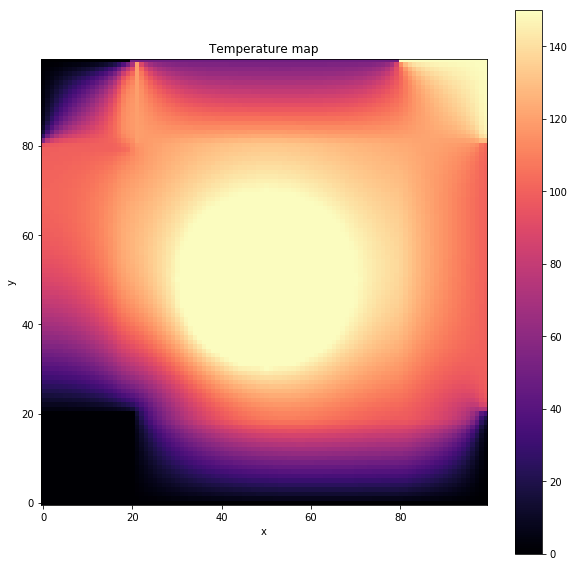

In [17]:
heatmap2d(temp)

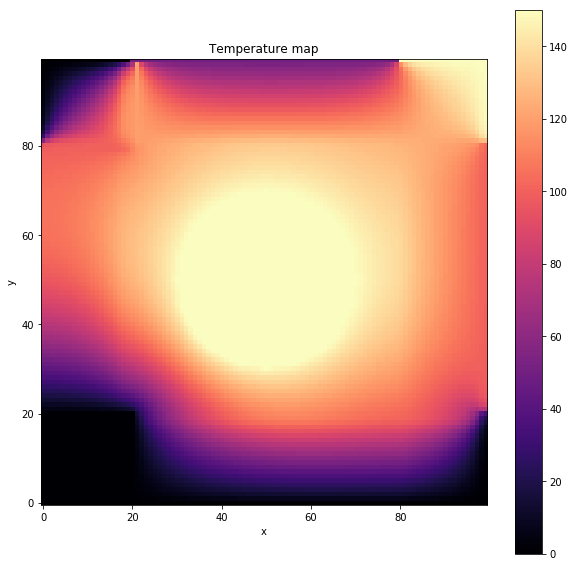

In [749]:
heatmap2d(temp_less)

## Для дебага

In [351]:
#Расчет с помощью прогонки
temp = np.zeros((len(x_set), len(y_set)))
counter = 1

while True:
    temp_prev = temp.copy()
    print(np.min(temp))
    
    
    #(lambds, t, s_c, s_p)
    temp = tridiagonal_matrix_algorithm_trans(lambda_set, temp, source_c, source_p)
    print(np.min(temp))
    
    temp = tridiagonal_matrix_algorithm_long(lambda_set, temp, source_c, source_p)
    print(np.min(temp))
    
    delta_temp = abs(temp_prev - temp)
    if np.amax(delta_temp) < 0.9:
        break
    
    print(np.min(temp))
    print("------")
    break

0.0
0.0
0.0
0.0
------


In [89]:
temp = np.zeros((len(x_set), len(y_set)))

lambds = lambda_set
t = temp
s_c = source_c
s_p = source_p

# def tridiagonal_matrix_algorithm_long(lambds, t, s_c, s_p):

kind = 'long'
k = 0
for k in range(len(x_set) - 1) :

    t_long = t[k, :]
    t_prev = t.copy()
    s_c_long = s_c[k,:]
    s_p_long = s_p[k,:]

    if k == 0 :
        lambds_low = lambds[0, :]
        t_long_low = t_prev[0, :]
    else :
        lambds_low = lambds[k - 1, :]
        t_long_low = t_prev[k - 1, :]
    try:
        t_long_up = t_prev[k + 1, :]
        lambds_up = lambds[k + 1, :]
    except IndexError:
        t_long_up = t_prev[k, :]
        lambds_up = lambds[k, :]

    alpha = np.zeros(len(t_long))
    betha = np.zeros(len(t_long))
    alpha[1], betha[1]= initial_cond_trans(k, lambds[0, :], alpha[-1], betha[-1], 'start')
    
    if k == 4 :
        break
    
    alpha, betha = coef_calc(alpha, betha, kind, lambds[0, :], t_long, t_long_up, t_long_low, s_c_long, s_p_long, lambds_up, lambds_low)   
    
    t[k, -1] = initial_cond_trans(k, lambds[0, :], alpha[-1], betha[-1], 'end')    
    for m in reversed(range(0, len(t_long) - 1)):
        t[k, m] = alpha[m+1] * t[k, m+1] + betha[m+1]
    
# print(t)

In [90]:
alpha = alpha
betha = betha
kind = kind
lambds = lambds[0, :]
t = t_long
t_up = t_long_up
t_low = t_long_low
s_c = s_c_long
s_p = s_p_long
lambds_up = lambds_up
lambds_low = lambds_low



#lambds - лямбды на оси неизвестных, lambds_up & lambds_low - лямбды выше и ниже (справа и слева)
if kind == 'long':
    size_x = X_STEP
    size_y = Y_STEP

elif kind == 'trans':
    size_x = Y_STEP
    size_y = X_STEP

with np.errstate(divide='ignore', invalid='ignore'):
    a = np.roll(lambds, 1) / (np.roll(lambds, 1) + lambds) / size_x ** 2
    b = np.roll(lambds, -1) / (np.roll(lambds, -1) + lambds) / size_x ** 2             
    c = (((np.roll(lambds, -1) + np.roll(lambds, 1)) * lambds + 
        2 * np.roll(lambds, -1) * np.roll(lambds, 1)) /
        (np.roll(lambds, -1) + lambds) / (np.roll(lambds, 1) + lambds) / size_x ** 2 + 
        ((lambds_up + lambds_low) * lambds + 2 * lambds_up * lambds_low) / (lambds_up + lambds) / 
        (lambds_low + lambds) / size_y ** 2 + s_p / (2 * lambds)) 
    d = (lambds_up / (lambds_up + lambds)* t_up / size_y ** 2 + lambds_low/ 
        (lambds_low + lambds)* t_low / size_y ** 2 + s_c / (2 * lambds))

a = np.nan_to_num(a)
b = np.nan_to_num(b)
c[np.isnan(c)] = 1
d[np.isnan(d)] = 0
d[np.isinf(d)] = 0

for i in range(1, len(t)-1):
    alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
    betha[i+1] = (a[i] * betha[i] + d[i]) / (c[i] - alpha[i] * a[i])
    
#     if i == 16:
#         break

In [85]:
i = 17
print(a[i])
print( betha[i] )
print(d[i])
print(a[i] * betha[i] + d[i])
print(c[i] - alpha[i] * a[i])

1.0
78.67900208540682
inf
inf
1.0


In [91]:
betha

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.45574370e-01, 1.10290847e-01, 4.56381456e-02, 1.86787416e-02,
       9.18379891e-03, 9.71147230e-03, 2.27621177e-02, 6.61597522e-02,
       1.95917438e-01, 5.73682557e-01, 1.65300834e+00, 4.67908816e+00,
       1.30001201e+01, 7.86790021e+01, 7.86790021e+01, 0.00000000e+00])

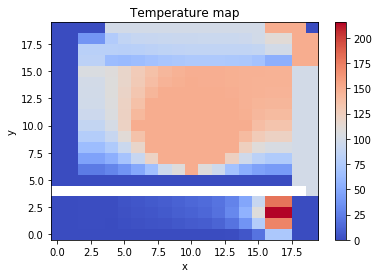

In [24]:
heatmap2d(temp)